#### Import libraries

In [82]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline
import pandas as pd
import scipy.sparse as sps
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#### Data analysis and Visualization

In [83]:
df = pd.read_csv('input/data_train.csv')
n_interactions = len(df)
n_users = len(df['row'].unique())
n_items = len(df['col'].unique())

In [84]:
def pretty(x):
    return '{:,}'.format(x).replace(',', "'")

print(f"\n{pretty(n_users)} unique users \n{pretty(n_items)} unique items \n{pretty(n_interactions)} total interactions")


13'650 unique users 
18'059 unique items 
5'285'664 total interactions


#### Personal Data loader

In [85]:
from data_loader import load_URM

URM_all = load_URM('input/data_train.csv')

#### Train - validation - test split

In [86]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13640 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions


#### Grid search for finding optimal value for TopK

In [87]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [100, 500, 700, 800, 900, 1000]
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1383.42 column/sec. Elapsed time 9.87 sec
EvaluatorHoldout: Processed 13640 (100.0%) in 5.64 sec. Users per second: 2420
UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1406.17 column/sec. Elapsed time 9.71 sec
EvaluatorHoldout: Processed 13640 (100.0%) in 9.76 sec. Users per second: 1398
UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1292.39 column/sec. Elapsed time 10.56 sec
EvaluatorHoldout: Processed 13640 (100.0%) in 11.02 sec. Users per second: 1238
UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to 

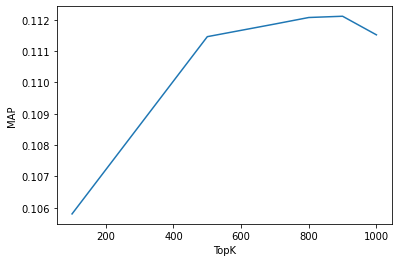

In [88]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

from the above graph, it seems that the optimal value for topK = 700

#### Grid search for finding the optimal value for shrinkage

In [89]:
x_tick = range(1,6)
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1495.98 column/sec. Elapsed time 9.12 sec
EvaluatorHoldout: Processed 13640 (100.0%) in 5.49 sec. Users per second: 2486
UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1506.66 column/sec. Elapsed time 9.06 sec
EvaluatorHoldout: Processed 13640 (100.0%) in 5.54 sec. Users per second: 2461
UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13650 (100.0%), 1402.92 column/sec. Elapsed time 9.73 sec
EvaluatorHoldout: Processed 13640 (100.0%) in 5.69 sec. Users per second: 2399
UserKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Py

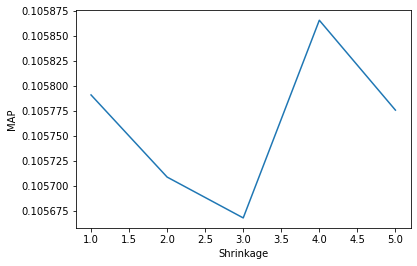

In [90]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

from the above graph, it seems that the optimal value for shrinkage = 0

In [91]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=700)

ItemKNNCFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 1305.78 column/sec. Elapsed time 13.83 sec


In [92]:
import pandas as pd
from tqdm import tqdm
submission = pd.DataFrame(columns=['user_id', 'item_list'])

for i in tqdm(range(n_users), desc="getting recommendations"):
    item_list = recommender.recommend(i, 10)
    submission.loc[i] = [i, ' '.join([str(i) for i in item_list])]

submission

getting recommendations: 100%|██████████| 13650/13650 [00:30<00:00, 447.98it/s]


,user_id,item_list
0,0,3899 13229 17788 2665 16365 3768 640 9131 1313...
1,1,3473 5925 9871 14400 8502 13914 1137 2665 1793...
2,2,3473 14181 3899 5273 17330 1551 13134 6177 621...
3,3,8194 15082 16359 3473 15551 3899 16365 17330 7...
4,4,3473 6214 13229 5273 8635 2665 5925 6177 15119...
...,...,...
13645,13645,3899 17330 1259 6177 13134 13914 9441 10865 11...
13646,13646,3473 6177 3899 8635 13134 14358 16846 5273 125...
13647,13647,3473 6177 8635 16365 2665 16846 17330 6975 131...
13648,13648,6177 3473 3899 6214 8635 13134 2665 15119 1418...


In [93]:
from datetime import datetime
submission.to_csv(f'output/cf_{str(datetime.now())}.csv', index=False)